Import an image to measure the background noise in it.

Note that Dragonfly007 (T13110627) had the G filter installed.

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid

%matplotlib inline

### Looking at the actual Dragonfly data...

In [2]:
imagefile='/Users/lokhorst/Desktop/T13110627_36_light.fits'
d,h = fits.getdata(imagefile,header=True)

print h['EXPTIME']

600.0


the median of the whole frame is 2028.0
the median of the small box of data is 1907.0
the standard deviation of the small box is 266.424744741
the median of the small box of data MASKED is 1907.0
the standard deviation of the small box MASKED is 60.1782741629


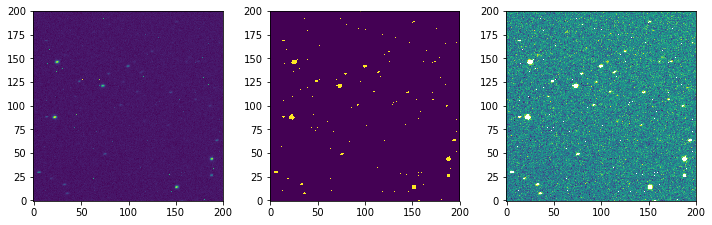

In [4]:
def plotdata(data,ax=None,bounds=None,colorbar=False):
    if ax is None:
        fig = plt.figure(figsize=(6, 3.2))
        ax = fig.add_subplot(111)
        oneplot=True
        ax.set_title('Pretend Data')
    if bounds is None:
        img = ax.imshow(data,origin='lower')
    else:
        img = ax.imshow(data,origin='lower',vmin=bounds[0],vmax=bounds[1])
    ax.set_aspect('equal')
    
    if colorbar:
        div = axgrid.make_axes_locatable(ax)
        cax = div.append_axes("right",size="10%",pad=0.15)
        cbar = plt.colorbar(img,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
        cbar.ax.tick_params()

# Plot a portion of the image
smaller_d = d[200:400,200:400]
print "the median of the whole frame is %s"%np.median(d)
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10, 16))
plotdata(np.log10(smaller_d),ax=ax1)

# Make a 3sigma mask
mask = np.zeros(smaller_d.shape)
med_data = np.median(smaller_d)
sigma_data = np.std(smaller_d)
mask[smaller_d>(med+1.*sigma)]=1.
print "the median of the small box of data is %s"%med_data
print "the standard deviation of the small box is %s"%sigma_data

# Plot the mask
plotdata(mask,ax=ax2)

# Try and mask the data with the 3sigma mask
mx = np.ma.masked_array(smaller_d, mask=mask)
med_masked = np.ma.median(mx)
sigma_masked = np.ma.std(mx)
print "the median of the small box of data MASKED is %s"%med_masked
print "the standard deviation of the small box MASKED is %s"%sigma_masked

plotdata(mx,ax=ax3)

# grow the mask a bit in all directinos
#growmask = morphology.grey_dilation(mask,(3,3))

plt.tight_layout()

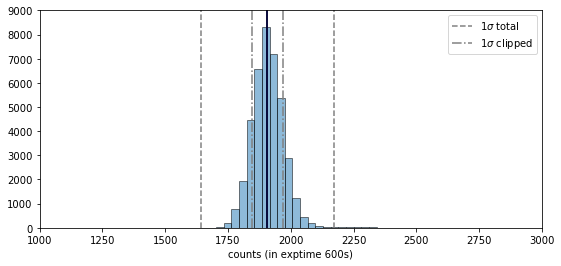

In [23]:
fig, (ax1) = plt.subplots(1, 1, figsize=(9, 4))
ax1.hist(np.ravel((smaller_d)),edgecolor='black', alpha = 0.5,bins=500)
ax1.set_xlim(1000,3000)
ax1.set_ylim(0,9000)
ax1.set_xlabel('counts (in exptime 600s)')

# line for the median of the total data
ax1.plot([med_data,med_data],[0,9000],color = 'blue')

# line for the median of the masked array
ax1.plot([med_masked,med_masked],[0,9000],'black')

# line for the standards deviations of total data and of the masked array
ax1.plot([med_data-sigma_data,med_data-sigma_data],[0,9000],'--',color='gray',label=r'1$\sigma$ total')
ax1.plot([med_data+sigma_data,med_data+sigma_data],[0,9000],'--',color='gray')

ax1.plot([med_masked-sigma_masked,med_masked-sigma_masked],[0,9000],'-.',color='gray',label=r'1$\sigma$ clipped')
ax1.plot([med_masked+sigma_masked,med_masked+sigma_masked],[0,9000],'-.',color='gray')
plt.legend()
plt.show()

The noise should be distributed in some normal or Poisson distribution, and that is what we see here.  The dashed lines are the standard deviation of the whole array, and the dash-dotted lines are the standard deviation of the sigma-clipped array.

### Adding noise from the G-band and comparing it to noise in the image

### Looking at the Needle image - attempt to measure S/N ratio

In [35]:
imagefile='/Users/lokhorst/Desktop/2017-04-02_coadd_SloanG.fits'
d_needle279,h_needle279 = fits.getdata(imagefile,header=True)

print np.float(h_needle279['NFRAMES'])

279.0


the median of the small box of data is 1097.93076653
the standard deviation of the small box is 574.498722345
the median of the small box of data MASKED is 1097.54603276
the standard deviation of the small box MASKED is 4.30634072439


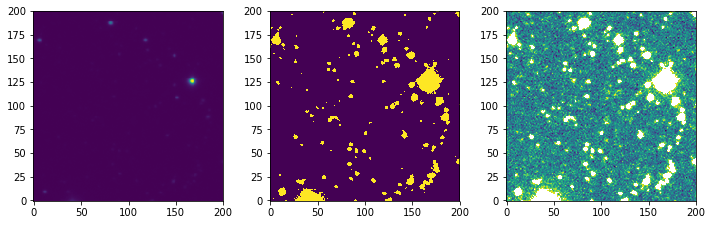

In [58]:
from astropy.stats import sigma_clip

def smallboxanalysis(data,center_x,center_y):
    smaller_d = data[center_x-100:center_x+100,center_y-100:center_y+100]
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10, 16))
    plotdata(np.log10(smaller_d),ax=ax1)
    
    # start sigma clipping
    # ROUGH: Make a 3sigma mask
    mask = np.zeros(smaller_d.shape)
    med_data = np.median(smaller_d)
    sigma_data = np.std(smaller_d)
    mask[smaller_d>(med+1.*sigma)]=1.
    print "the median of the small box of data is %s"%med_data
    print "the standard deviation of the small box is %s"%sigma_data
    #plotdata(mask,ax=ax2)
    
    # BETTER: do iterative sigma clipping
    clipped_zp  = sigma_clip(smaller_d, sig=3, iters = 5)
    outliers    = clipped_zp.mask
    plotdata(outliers,ax=ax2)
    
    # Then
    mx = np.ma.masked_array(smaller_d, mask=outliers)
    med_masked = np.ma.median(mx)
    sigma_masked = np.ma.std(mx)
    print "the median of the small box of data MASKED is %s"%med_masked
    print "the standard deviation of the small box MASKED is %s"%sigma_masked
    plotdata(mx,ax=ax3)

    # grow the mask a bit in all directinos
    #growmask = morphology.grey_dilation(mask,(3,3))
    plt.tight_layout()
    
    return

smallboxanalysis(d_needle279,2100,2100)

In [ ]:
def plothist(data,center_x,center_y):
    smaller_d = data[center_x-100:center_x+100,center_y-100:center_y+100]
    fig, (ax1) = plt.subplots(1, 1, figsize=(9, 4))
    
    # ravel out the array
    clipped_zp  = sigma_clip(np.ravel(smaller_d), sig=3, iters = 5)
    outliers    = clipped_zp.mask
    mx = np.ma.masked_array(np.ravel(smaller_d), mask=outliers)[~outliers]
    
    ax1.hist(mx,edgecolor='black', alpha = 0.5,bins=50)
    ax1.set_xlabel('counts')
    maxy = 2100
    
    # line for the median of the masked array
    ax1.plot([mx,mx],[0,maxy],'black')
    med_masked = np.median(mx)
    sigma_masked = np.std(mx)

    # line for the standards deviations 
    ax1.plot([med_masked-sigma_masked,med_masked-sigma_masked],[0,maxy],'--',color='gray')
    ax1.plot([med_masked+sigma_masked,med_masked+sigma_masked],[0,maxy],'--',color='gray')

    plt.show()
    
plothist(d_needle279,2100,2100)

In [ ]:
imagenames = ['2017-04-02_T13090552_16_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
              '2017-04-02_T13110598_31_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
              '2017-04-02_T13110627_36_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
              '2017-04-02_T13090562_23_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
              '2017-04-02_T13110625_22_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
              '2017-04-02_T13110630_19_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
              '2017-04-02_T13090571_19_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
              '2017-04-02_T13110627_21_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
              '2017-04-02_T13110630_40_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
              '2017-04-02_T13100579_15_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
              '2017-04-02_T13110627_26_light_ds_ff_wcs_sms_reg_pcp_pcr.fits']


for image in imagenames:
    print image